<h1 style=\"text-align: center; font-size: 50px;\">✍️ [MLFlow] MNIST with Keras </h1>
This notebook shows how to do a simple image classification using TensorFlow and MNIST(Modified National Institute of Standards and Technology) database of handwritten digits.


## Notebook Overview
- Imports
- Configurations
- Loading and Preprocessing the Data
- Building Model
- Training the Model
- Making inferences
- Logging Model to MLflow + Tensoboard
- Fetching the Latest Model Version from MLflow
- Loading the Model and Running Inference


## Imports

In [ ]:
# ------------------------ System Utilities ------------------------
import warnings                         
import logging  
import datetime          

# ------------------------ Data manipulation libraries ------------------------
import pandas as pd                     
import numpy as np

# ------------------------ Visualization Libraries ------------------------ 
import matplotlib.pyplot as plt

# ------------------------ Deep learning framework ------------------------
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import torch
from tensorflow.keras.callbacks import TensorBoard

# ------------------------ MLflow Integration ------------------------
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec, TensorSpec, ParamSchema, ParamSpec
import mlflow.keras

2025-05-14 15:27:45.900226: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 15:27:45.908519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747236465.918056    4095 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747236465.920794    4095 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 15:27:45.930524: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Configurations

In [2]:
# Suppress Python warnings
warnings.filterwarnings("ignore")

In [3]:
# Create logger
logger = logging.getLogger("MNIST_logger")
logger.setLevel(logging.INFO)

formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s", 
                              datefmt="%Y-%m-%d %H:%M:%S")  

stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.propagate = False

In [4]:
# ------------------------- Paths -------------------------
LOG_DIR = "/phoenix/tensorboard/tensorlogs/"

# ------------------------- MLflow Experiment Configuration -------------------------
EXPERIMENT_NAME = 'MNIST with TensorFlow 2'
RUN_NAME = "MNIST_Run"
MODEL_NAME = "MNIST_Model"
MODEL_PATH = "model_keras_mnist.keras"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

2025-05-14 15:27:48 - INFO - Using device: cuda


In [6]:
logger.info('Notebook execution started.')

2025-05-14 15:27:48 - INFO - Notebook execution started.


## Loading and Preprocessing the Data

The MNIST dataset is divided into two categories: training and testing sets. The load_data() function splits into x_train and y_train, coitaining images and their labels, for trainining the model. The other part, x_test and y_test, hold images and their labels for testing the model.

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
print("X:",type(x_train))
print("Y:",type(y_train))

X: <class 'numpy.ndarray'>
Y: <class 'numpy.ndarray'>


In [ ]:
# One-hot encode
y_cat_test = to_categorical(y_test,10)
y_cat_train = to_categorical(y_train,10)

Reshape to include channel dimension (in this case, 1 channel)

In [ ]:
x_train = x_train.reshape(60000, 28, 28, 1).astype('float32')/255

In [ ]:
x_test = x_test.reshape(10000,28,28,1).astype('float32')/255

## Building the Model

In [14]:
model = Sequential()

# CONVOLUTIONAL LAYER
model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(28, 28, 1), activation='relu',))
# POOLING LAYER
model.add(MaxPool2D(pool_size=(2, 2)))

# FLATTEN IMAGES FROM 28 by 28 to 764 BEFORE FINAL LAYER
model.add(Flatten())

# 128 NEURONS IN DENSE HIDDEN LAYER (YOU CAN CHANGE THIS NUMBER OF NEURONS)
model.add(Dense(128, activation='relu'))

# LAST LAYER IS THE CLASSIFIER, THUS 10 POSSIBLE CLASSES
model.add(Dense(10, activation='softmax'))

model.summary()

I0000 00:00:1747236468.470597    4095 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2268 MB memory:  -> device: 0, name: NVIDIA T600, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 25, 25, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 591,786 (2.26 MB)

 Trainable params: 591,786 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# https://keras.io/metrics/
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # you can add in additional metrics https://keras.io/metrics/

In [16]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
log_dir = LOG_DIR + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callback.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

## Training the Model

In [ ]:
history = model.fit(x_train,y_cat_train,epochs=4,validation_data=(x_test,y_cat_test),callbacks=[tensorboard_callback,early_stop])

Epoch 1/4


I0000 00:00:1747236469.855245    4194 service.cc:148] XLA service 0x7f3898005640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747236469.855270    4194 service.cc:156]   StreamExecutor device (0): NVIDIA T600, Compute Capability 7.5
2025-05-14 15:27:49.867629: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747236469.920040    4194 cuda_dnn.cc:529] Loaded cuDNN version 90300


  72/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6377 - loss: 1.2126  

I0000 00:00:1747236470.976521    4194 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9143 - loss: 0.2888 - val_accuracy: 0.9768 - val_loss: 0.0720
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9852 - loss: 0.0507 - val_accuracy: 0.9860 - val_loss: 0.0406
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9913 - loss: 0.0288 - val_accuracy: 0.9878 - val_loss: 0.0351
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9942 - loss: 0.0185 - val_accuracy: 0.9867 - val_loss: 0.0452


In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test,y_cat_test, verbose = 0)

In [18]:
model.save(MODEL_PATH)

## Making inferences

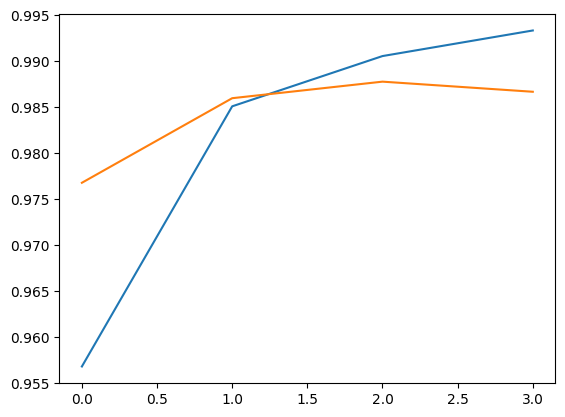

In [19]:
plt.plot(history.history['accuracy'], label = "Train accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation accuracy")

## Logging Model to MLflow

In [ ]:
class MNISTModel(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        """
        Load keras model.
        """
        try:
            # Load Iris Flower data
            self.model = load_model(context.artifacts["keras_model"])

        except Exception as e:
            logger.error(f"Error loading context: {str(e)}")
            raise

    def predict(self, context, model_input, params = None):
        """
        Computes the predicted digit.
        """
        try:

            if isinstance(model_input, pd.DataFrame):
                model_input = model_input.values

            if len(model_input.shape) == 3:
                model_input = model_input.reshape(model_input.shape[0], 28, 28, 1)
            elif len(model_input.shape) == 2:
                model_input = model_input.reshape(model_input.shape[0], 28, 28, 1)

            if model_input.max() > 1.0:
                model_input = model_input.astype('float32') / 255.0

            predictions = self.model.predict(model_input)

            return predictions

            # images = np.stack(model_input["image"].value)
            # predictions = self.model.predict(images)

            # return pd.DataFrame({"prediction": np.argmax(predictions, axis = 1)})
        
        except Exception as e:
            logger.error(f"Error performing prediction: {str(e)}")
            raise
    
    @classmethod
    def log_model(cls, model_name):
        """
        Logs the model to MLflow with appropriate artifacts and schema.
        """
        try:
            # Define input and output schema
            input_schema = Schema([
                TensorSpec(np.dtype(np.float32), (-1, 28, 28, 1), name = "image"),
                ])
            output_schema = Schema([
                TensorSpec(np.dtype(np.float32), (-1, 10),name = "prediction"),
            ])
            
            # Define model signature
            signature = ModelSignature(inputs=input_schema, outputs=output_schema)
            
            # Log the model in MLflow
            mlflow.pyfunc.log_model(
                model_name,
                python_model=cls(),
                artifacts={
                    "keras_model": MODEL_PATH,           
                },
                signature=signature,

            )
        except Exception as e:
            logger.error(f"Error logging model: {str(e)}")
            raise   

In [ ]:
logger.info(f'Starting the experiment: {EXPERIMENT_NAME}')

# Set the MLflow experiment name
mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

# Start an MLflow run
with mlflow.start_run(run_name=RUN_NAME) as run:
    # Print the artifact URI for reference
    logging.info(f"Run's Artifact URI: {run.info.artifact_uri}")
    
    mlflow.log_metrics("test_accuracy", test_accuracy)
    mlflow.log_metrics("test_lost", test_loss)

    # Log the model to MLflow
    MNISTModel.log_model(model_name=MODEL_NAME)

    # Register the logged model in MLflow Model Registry
    mlflow.register_model(
        model_uri=f"runs:/{run.info.run_id}/{MODEL_NAME}", 
        name=MODEL_NAME
    )

logger.info(f'Registered the model: {MODEL_NAME}')

2025-05-14 15:28:12 - INFO - Starting the experiment: MNIST with TensorFlow 2


Registered model 'MNIST_Model' already exists. Creating a new version of this model...
Created version '5' of model 'MNIST_Model'.
2025-05-14 15:28:17 - INFO - Registered the model: MNIST_Model


## Fetching the Latest Model Version from MLflow

In [22]:
# Initialize the MLflow client
client = MlflowClient()

# Retrieve the latest version of the "Iris_Flower_Model" model (not yet in a specific stage)
model_metadata = client.get_latest_versions(MODEL_NAME, stages=["None"])
latest_model_version = model_metadata[0].version  # Extract the latest model version

# Fetch model information, including its signature
model_info = mlflow.models.get_model_info(f"models:/{MODEL_NAME}/{latest_model_version}")

# Print the latest model version and its signature
print(f"Latest Model Version: {latest_model_version}")
print(f"Model Signature: {model_info.signature}")

Latest Model Version: 5
Model Signature: inputs: 
  [Tensor('float32', (5, 28, 28, 1))]
outputs: 
  [Tensor('int64', (-1,))]
params: 
  None



## Loading the Model and Running Inference

In [ ]:
model = mlflow.pyfunc.load_model(model_uri=f"models:/{MODEL_NAME}/{latest_model_version}")

sample_images = x_test[:5]
# example_image = x_test[0]
# input_df = pd.DataFrame({"image":[example_image]})

predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis = 1)

print(f"Prediction classes:", {predicted_classes})

MlflowException: Failed to enforce schema of data '[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]]' with schema '[Tensor('float32', (5, 28, 28, 1))]'. Error: dtype of input float64 does not match expected dtype float32

In [ ]:
logger.info('Notebook execution completed.')

Built with ❤️ using [**Z by HP AI Studio**](https://zdocs.datascience.hp.com/docs/aistudio/overview).